In [97]:
import datetime as dt
import pandas as pd
import numpy as np
import quandl
quandl.ApiConfig.api_key = 'TFPsUSNkbZiK8TgJJ_qa'

In [122]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [99]:
start_date = dt.date(2006,11,1)
end_date = dt.date(2015,12,31)

In [100]:
mkt = quandl.get('YAHOO/INDEX_GSPC',start_date=start_date,end_date=end_date)

In [101]:
mkt['val'] = mkt['Adjusted Close']
mkt['volume'] = mkt['Volume']
mkt['r'] = np.log(mkt['Close']/mkt['Open'])
mkt = mkt[['val','volume','r']]

In [102]:
mkt['r'] = (mkt.r-mkt.r.mean())/mkt.r.std()
mkt['tr'] = mkt.r.shift(-1)

In [103]:
vix = quandl.get('CBOE/VIX',start_date=start_date,end_date=end_date)

In [104]:
vix['vix'] = vix['VIX Close']
vix = vix[['vix']]

In [105]:
mkt = mkt.join(vix)

In [106]:
mkt['vals'] = (mkt.val - mkt.val.mean())/mkt.val.std()
mkt['vixs'] = (mkt.vix - mkt.vix.mean())/mkt.vix.std()

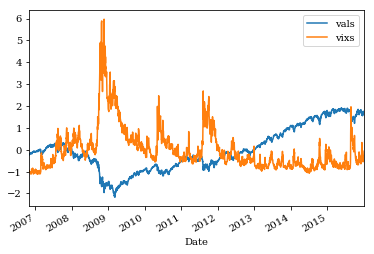

In [107]:
mkt[['vals','vixs']].plot();

In [108]:
mkt['yval'] = mkt.val.shift(1)
mkt['yvix'] = mkt.vix.shift(1)
mkt['lvix'] = np.log(mkt.vix)
mkt['lyvix'] = np.log(mkt.yvix)

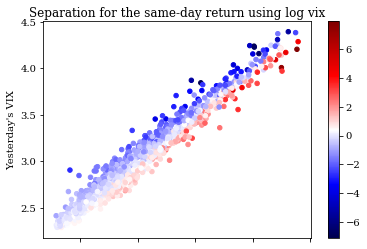

In [109]:
mkt.plot.scatter('lyvix','lvix',c=mkt.r,cmap='seismic');
plt.title('Separation for the same-day return using log vix');
plt.xlabel('Today\'s VIX');
plt.ylabel('Yesterday\'s VIX');

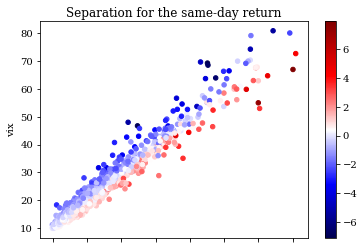

In [123]:
mkt.plot.scatter('yvix','vix',c=mkt.r,cmap='seismic');
plt.title('Separation for the same-day return');

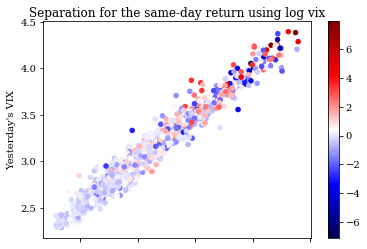

In [110]:
mkt.plot.scatter('lyvix','lvix',c=mkt.tr,cmap='seismic');
plt.title('Separation for the same-day return using log vix');
plt.xlabel('Today\'s VIX');
plt.ylabel('Yesterday\'s VIX');

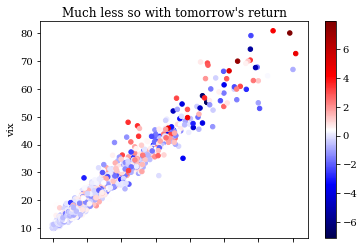

In [112]:
mkt.plot.scatter('yvix','vix',c=mkt.tr,cmap='seismic');
plt.title('Much less so with tomorrow\'s return');

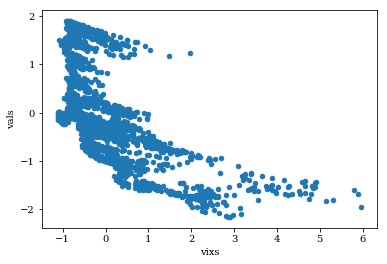

In [113]:
mkt.plot.scatter('vixs','vals');

In [127]:
import cvxpy as cvx

In [285]:
n = len(mkt)-2
X = mkt[['lyvix','lvix']]
# X = (X-X.mean())/X.std()
X = X.values[1:-1,:]              # Remove first point because there is a naan
X = np.column_stack((X,np.ones(n)))
r = mkt.r.values[1:-1]
tr = mkt.tr.values[1:-1]

X,X_test = X[:1800],X[1800:]
r,r_test = r[:1800],r[1800:]
tr,tr_test = tr[:1800],tr[1800:]

In [299]:
def solve(u,l,r):
    _,m = X.shape
    q = cvx.Variable(m)
    obj = cvx.sum_entries(u(cvx.mul_elemwise(r,X*q))) - l*cvx.norm(q)**2
    prob = cvx.Problem(cvx.Maximize(obj))
    prob.solve()
    q = q.value.A1
    return q

In [305]:
rnu = lambda x:x
expu = lambda x: -cvx.exp(-x)

In [307]:
ls = np.logspace(-1,1.3,10)
qs = [solve(rnu,l,r) for l in ls]
inps = [np.mean(r*(X@q)) for q in qs]
outps = [np.mean(r_test*(X_test@q)) for q in qs]

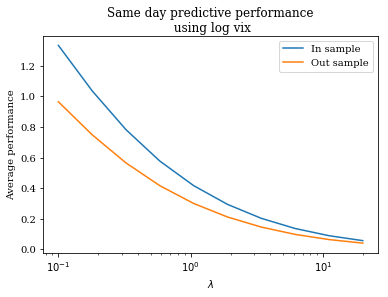

In [310]:
plt.plot(ls,inps,ls,outps)
plt.xscale('log')
plt.legend(['In sample','Out sample'])
plt.xlabel('$\lambda$');
plt.ylabel('Average performance')
plt.title('Same day predictive performance\n using log vix');

In [290]:
ls = np.logspace(-1,1.3,10)
qs = [solve(rnu,l,tr) for l in ls]
tinps = [np.mean(tr*(X@q)) for q in qs]
toutps = [np.mean(tr_test*(X_test@q)) for q in qs]

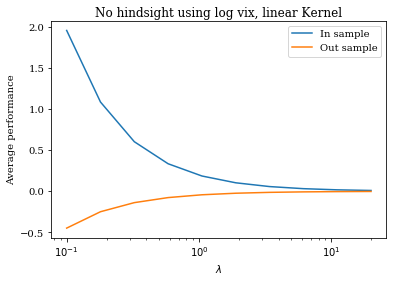

In [292]:
plt.plot(ls,tinps,ls,toutps)
plt.xscale('log')
plt.legend(['In sample','Out sample'])
plt.xlabel('$\lambda$');
plt.ylabel('Average performance')
plt.title('Total hindsight using log vix');
plt.title('No hindsight using log vix, linear Kernel');